<a href="https://colab.research.google.com/github/tomaszgawron901/deep-learning-23-project/blob/tomaszgawron901%2Fmain/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone Repo

In [ ]:
# if running in google colab clone the repository and move into it
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/tomaszgawron901/deep-learning-23-project.git
    %cd deep-learning-23-project/
    # !git checkout <branch>

# Workspace

Files already downloaded and verified


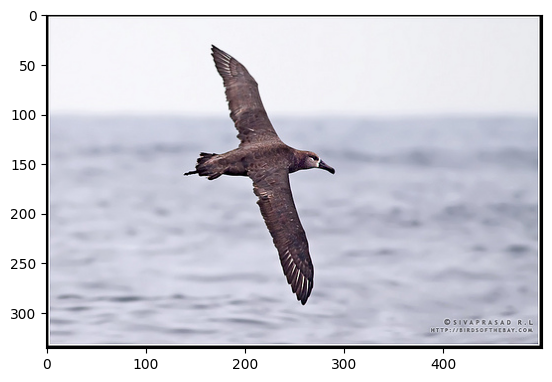

In [4]:
from torchvision import transforms
import matplotlib.pyplot as plt
import os


from cub200 import Cub2011

dataset = Cub2011(os.path.abspath("./data"),
                  train=True,
                  transform=transforms.ToTensor())

for img, target in dataset:
    plt.imshow(img.permute(1, 2, 0))
    break
